#verify pyEMU results with the henry problem

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyemu

instaniate ```pyemu``` object and drop prior info.  Then reorder the jacobian and save as binary.  This is needed because the pest utilities require strict order between the control file and jacobian

In [3]:
la = pyemu.Schur("freyberg.jcb",verbose=False,forecasts=[])
la.drop_prior_information()
jco_ord = la.jco.get(la.pst.obs_names,la.pst.par_names)
ord_base = "freyberg_ord"
jco_ord.to_binary(ord_base + ".jco")  
la.pst.write(ord_base+".pst")

extract and save the forecast sensitivity vectors

In [4]:
pv_names = []
predictions =  ["sw_gw_0","sw_gw_1","or28c05_0","or28c05_1"]
for pred in predictions:
    pv = jco_ord.extract(pred).T
    pv_name = pred + ".vec"
    pv.to_ascii(pv_name)
    pv_names.append(pv_name)
    

save the prior parameter covariance matrix as an uncertainty file

In [5]:
prior_uncfile = "pest.unc"
la.parcov.to_uncfile(prior_uncfile,covmat_file=None)

#PRECUNC7
write a response file to feed ```stdin``` to ```predunc7```

In [6]:
post_mat = "post.cov"
post_unc = "post.unc"
args = [ord_base + ".pst","1.0",prior_uncfile,
        post_mat,post_unc,"1"]
pd7_in = "predunc7.in"
f = open(pd7_in,'w')
f.write('\n'.join(args)+'\n')
f.close()
out = "pd7.out"
pd7 = os.path.join("exe","i64predunc7.exe")
os.system(pd7 + " <" + pd7_in + " >"+out)
for line in open(out).readlines():
    print line,


 PREDUNC7 Version 13.3. Watermark Numerical Computing.

 Enter name of PEST control file:  Enter observation reference variance: 
 Enter name of prior parameter uncertainty file: 
 Enter name for posterior parameter covariance matrix file:  Enter name for posterior parameter uncertainty file: 
 Use which version of linear predictive uncertainty equation:-
     if version optimized for small number of parameters   - enter 1
     if version optimized for small number of observations - enter 2
 Enter your choice: 
 - reading PEST control file freyberg_ord.pst....
 - file freyberg_ord.pst read ok.

 - reading Jacobian matrix file freyberg_ord.jco....
 - file freyberg_ord.jco read ok.

 - reading parameter uncertainty file pest.unc....
 - parameter uncertainty file pest.unc read ok.
 - forming XtC-1(e)X matrix....
 - inverting prior C(p) matrix....
 - inverting [XtC-1(e)X + C-1(p)] matrix....
 - writing file post.cov...
 - file post.cov written ok.
 - writing file post.unc...
 - file post.

load the posterior matrix written by ```predunc7```

In [10]:
post_pd7 = pyemu.Cov.from_ascii(post_mat)

la_ord = pyemu.Schur(jco=ord_base+".jco",predictions=predictions)
post_pyemu = la_ord.posterior_parameter
#post_pyemu = post_pyemu.get(post_pd7.row_names)

The cumulative difference between the two posterior matrices:

In [12]:
delta = (post_pd7 - post_pyemu).x
(post_pd7 - post_pyemu).to_ascii("delta.cov")
print delta.sum()
print delta.max(),delta.min()

-6.64002683041e-06
4.98006134109e-08 -5.01255543739e-08


A few more metrics ...

In [15]:
print((delta.sum()/post_pyemu.x.sum()) * 100.0)
print(np.abs(delta).sum())

-4.83858502274e-06
2.96658856211e-05


#PREDUNC1
write a response file to feed ```stdin```.  Then run ```predunc1``` for each forecast

In [8]:
args = [ord_base + ".pst", "1.0", prior_uncfile, None, "1"]
pd1_in = "predunc1.in"
pd1 = os.path.join("exe", "i64predunc1.exe")
pd1_results = {}
for pv_name in pv_names:
    args[3] = pv_name
    f = open(pd1_in, 'w')
    f.write('\n'.join(args) + '\n')
    f.close()
    out = "predunc1" + pv_name + ".out"
    os.system(pd1 + " <" + pd1_in + ">" + out)
    f = open(out,'r')
    for line in f:
        if "pre-cal " in line.lower():
            pre_cal = float(line.strip().split()[-2])
        elif "post-cal " in line.lower():
            post_cal = float(line.strip().split()[-2])
    f.close()        
    pd1_results[pv_name.split('.')[0].lower()] = [pre_cal, post_cal]  
   
  

organize the ```pyemu``` results into a structure for comparison

In [16]:
# save the results for verification testing
pd.DataFrame(pd1_results).to_csv("predunc1_results.dat")

In [12]:
pyemu_results = {}
for pname in la_ord.prior_prediction.keys():
    pyemu_results[pname] = [np.sqrt(la_ord.prior_prediction[pname]),
                            np.sqrt(la_ord.posterior_prediction[pname])]

compare the results:

In [13]:
f = open("predunc1_textable.dat",'w')
for pname in pd1_results.keys():
    print pname
    f.write(pname+"&{0:6.5f}&{1:6.5}&{2:6.5f}&{3:6.5f}\\\n"\
            .format(pd1_results[pname][0],pyemu_results[pname][0],
                    pd1_results[pname][1],pyemu_results[pname][1]))
    print "prior",pname,pd1_results[pname][0],pyemu_results[pname][0]
    print "post",pname,pd1_results[pname][1],pyemu_results[pname][1]
f.close()

sw_gw_1
prior sw_gw_1 788.1179 788.117930411
post sw_gw_1 787.6817 787.681800039
sw_gw_0
prior sw_gw_0 282.195 282.195029354
post sw_gw_0 212.7603 212.760315313
or28c05_1
prior or28c05_1 1.206773 1.20677301488
post or28c05_1 1.161617 1.16161659921
or28c05_0
prior or28c05_0 0.6332639 0.633263879184
post or28c05_0 0.323884 0.323883980972


##PREDVAR1b
write the nessecary files to run ```predvar1b```

In [14]:
f = open("pred_list.dat",'w')
out_files = []
for pv in pv_names:
    out_name = pv+".predvar1b.out"
    out_files.append(out_name)
    f.write(pv+" "+out_name+"\n")
f.close()
args = [ord_base+".pst","1.0","pest.unc","pred_list.dat"]
for i in xrange(36):
    args.append(str(i))
args.append('')    
args.append("n")
args.append("n")
args.append("y")
args.append("n")
args.append("n")
f = open("predvar1b.in", 'w')
f.write('\n'.join(args) + '\n')
f.close()

os.system("exe\\predvar1b.exe <predvar1b.in")


0

In [15]:
pv1b_results = {}
for out_file in out_files:
    pred_name = out_file.split('.')[0]
    f = open(out_file,'r')
    for _ in xrange(3):
        f.readline()
    arr = np.loadtxt(f)
    pv1b_results[pred_name] = arr


now for pyemu

In [18]:
omitted_parameters = [pname for pname in la.pst.parameter_data.parnme if pname.startswith("wf")]
la_ord_errvar = pyemu.ErrVar(jco=ord_base+".jco",
                             predictions=predictions,
                             omitted_parameters=omitted_parameters,
                             verbose=False)
df = la_ord_errvar.get_errvar_dataframe(np.arange(36))
df

first                                                 second  \
   or28c05_0 or28c05_1        sw_gw_0         sw_gw_1     or28c05_0   
0   0.400026  1.399895   77533.592215   528441.245961  0.000000e+00   
1   0.208846  1.364066  108687.070550   528675.175679  1.773993e-05   
2   0.134608  1.335394  106758.010109   528670.674069  2.962957e-05   
3   0.116149  1.322323  105651.239320   528644.229942  3.452397e-05   
4   0.114077  1.317549  102618.177636   528642.555795  3.560572e-05   
5   0.113955  1.317548  102247.584169   528501.494334  3.568542e-05   
6   0.111691  1.311337  100763.341086   528496.335777  3.732786e-05   
7   0.105424  1.302422   99459.069459   528472.170944  4.254574e-05   
8   0.105259  1.300935   89775.718975   528268.280298  4.275407e-05   
9   0.105258  1.300840   89258.742133   528259.236880  4.275464e-05   
10  0.105258  1.300817   89180.821764   528258.871542  4.275483e-05   
11  0.105254  1.300656   88235.124799   528248.133869  4.276376e-05   
12  0.105247  1.300509   87472.153964   528237.286876  4.278264e-05   
13  0.105227  1.300101   85218.917993   528209.164989  4.284878e-05   
14  0.105222  2.404814   85217.528885  1267575.578230  1.000000e+35   
15  0.105215  2.625602   85217.512010  1415357.496505  1.000000e+35   
16  0.105202  3.457942   85217.434586  1969038.350374  1.000000e+35   
17  0.105165  3.054539   85216.768234  1704758.094920  1.000000e+35   
18  0.105164  3.054538   85216.707138  1704755.311180  1.000000e+35   
19  0.105143  2.905567   85215.907173  1601736.578709  1.000000e+35   
20  0.105142  2.843310   85215.715729  1561225.120054  1.000000e+35   
21  0.105128  2.224884   85214.684434  1151063.868640  1.000000e+35   
22  0.105030  2.219851   85214.207555  1147087.826935  1.000000e+35   
23  0.105015  1.278779   85214.209763   516628.823956  1.000000e+35   
24  0.105004  1.243652   85213.262934   493205.443858  1.000000e+35   
25  0.104964  1.164786   85213.239460   439094.151325  1.000000e+35   
26  0.104604  1.141175   85212.626700   426410.142478  1.000000e+35   
27  0.104255  1.139577   85212.137334   426007.291920  1.000000e+35   
28  0.103864  1.103103   85210.854565   406913.896150  1.000000e+35   
29  0.103860  1.076403   85210.579193   389569.939304  1.000000e+35   
30  0.103792  1.035944   85210.577098   364621.254757  1.000000e+35   
31  0.103361  1.009435   85209.744859   343280.037967  1.000000e+35   
32  0.103361  1.001257   85207.784695   337992.627857  1.000000e+35   
33  0.103358  0.933209   85206.408219   291815.602822  1.000000e+35   
34  0.103188  0.913349   85204.763510   280468.873266  1.000000e+35   
35  0.103031  0.911659   85202.504792   278736.770297  1.000000e+35   

                                                     third                \
       or28c05_1       sw_gw_0       sw_gw_1     or28c05_0     or28c05_1   
0   0.000000e+00  0.000000e+00  0.000000e+00  9.967783e-04  5.640637e-02   
1   9.856142e-07  1.377404e+01  1.524245e-01  4.836506e-04  5.639341e-02   
2   5.573815e-06  1.408484e+01  1.531363e-01  3.195447e-04  5.640914e-02   
3   9.041950e-06  1.437952e+01  1.601675e-01  2.917844e-04  5.643324e-02   
4   1.154041e-05  1.597257e+01  1.610202e-01  2.733668e-04  5.640851e-02   
5   1.154122e-05  1.621398e+01  2.526565e-01  2.739573e-04  5.640861e-02   
6   1.605549e-05  1.729784e+01  2.563579e-01  2.768196e-04  5.642986e-02   
7   2.348444e-05  1.838852e+01  2.765489e-01  2.443812e-04  5.642432e-02   
8   2.536176e-05  3.061537e+01  5.337179e-01  2.482434e-04  5.642850e-02   
9   2.549846e-05  3.135681e+01  5.466774e-01  2.482656e-04  5.642630e-02   
10  2.554081e-05  3.150010e+01  5.473506e-01  2.482579e-04  5.642648e-02   
11  2.585254e-05  3.332549e+01  5.680754e-01  2.482857e-04  5.642646e-02   
12  2.625008e-05  3.540222e+01  5.975862e-01  2.485287e-04  5.642710e-02   
13  2.765268e-05  4.314313e+01  6.941755e-01  2.491958e-04  5.643073e-02   
14  1.000000e+35  1.000000e+35  1.000000e+35  1.000000e+35  1.000000e+35   
15  1.000000e+35

generate some plots to verify

In [ ]:
fig = plt.figure(figsize=(6,8))
max_idx = 13
idx = np.arange(max_idx)
for ipred,pred in enumerate(predictions):
    arr = pv1b_results[pred][:max_idx,:]
    first = df[("first", pred)][:max_idx]
    second = df[("second", pred)][:max_idx]
    third = df[("third", pred)][:max_idx]
    ax = plt.subplot(len(predictions),1,ipred+1)
    #ax.plot(arr[:,1],color='b',dashes=(6,6),lw=4,alpha=0.5)
    #ax.plot(first,color='b')
    #ax.plot(arr[:,2],color='g',dashes=(6,4),lw=4,alpha=0.5)
    #ax.plot(second,color='g')
    #ax.plot(arr[:,3],color='r',dashes=(6,4),lw=4,alpha=0.5)
    #ax.plot(third,color='r')
    
    ax.scatter(idx,arr[:,1],marker='x',s=40,color='g',
               label="PREDVAR1B - first term")
    ax.scatter(idx,arr[:,2],marker='x',s=40,color='b',
               label="PREDVAR1B - second term")
    ax.scatter(idx,arr[:,3],marker='x',s=40,color='r',
               label="PREVAR1B - third term")
    ax.scatter(idx,first,marker='o',facecolor='none',
               s=50,color='g',label='pyEMU - first term')
   
    ax.scatter(idx,second,marker='o',facecolor='none',
               s=50,color='b',label="pyEMU - second term")
    
    ax.scatter(idx,third,marker='o',facecolor='none',
               s=50,color='r',label="pyEMU - third term")
    ax.set_ylabel("forecast variance")
    ax.set_title("forecast: " + pred)
    if ipred == len(predictions) -1:
        ax.legend(loc="lower center",bbox_to_anchor=(0.5,-0.75),
                  scatterpoints=1,ncol=2)
        ax.set_xlabel("singular values")
    else:
        ax.set_xticklabels([])
    #break
plt.savefig("predvar1b_ver.eps")    
    

#Identifiability

In [19]:
cmd_args = [os.path.join("exe","i64identpar.exe"),ord_base,"5",
            "null","null","ident.out","/s"]
cmd_line = ' '.join(cmd_args)+'\n'
print(cmd_line)
print(os.getcwd())
os.system(cmd_line)

exe\i64identpar.exe freyberg_ord 5 null null ident.out /s

D:\Home\git\pyemu\verification\Freyberg


0

In [20]:
identpar_df = pd.read_csv("ident.out",delim_whitespace=True)

In [21]:
la_ord_errvar = pyemu.ErrVar(jco=ord_base+".jco",
                             predictions=predictions,
                             verbose=False)
df = la_ord_errvar.get_identifiability_dataframe(5)
df

,right_sing_vec_1,right_sing_vec_2,right_sing_vec_3,right_sing_vec_4,right_sing_vec_5,ident
rch_1,9.955541e-01,7.052885e-04,1.590869e-04,1.422682e-04,9.111534e-06,9.965699e-01
rch_2,0.000000e+00,3.081488e-33,6.240013e-32,4.437343e-31,4.930381e-32,5.585197e-31
rcond00,1.773061e-09,2.743063e-07,1.998841e-06,1.088365e-06,4.402964e-07,3.803581e-06
rcond01,4.584440e-09,6.548507e-07,4.284359e-06,2.287944e-06,8.918623e-07,8.123601e-06
rcond02,4.584440e-09,6.548507e-07,4.284359e-06,2.287944e-06,8.918623e-07,8.123601e-06
rcond03,9.277334e-09,1.267948e-06,7.720672e-06,3.952089e-06,1.396724e-06,1.434671e-05
rcond04,8.516417e-09,1.209669e-06,7.811702e-06,4.083723e-06,1.513522e-06,1.462713e-05
rcond05,4.054379e-09,6.131614e-07,4.352238e-06,2.388358e-06,9.856649e-07,8.343477e-06
rcond06,1.773061e-09,2.743063e-07,1.998841e-06,1.088365e-06,4.402964e-07,3.803581e-06
rcond07,1.627707e-11,6.855104e-10,2.667497e-10,1.078215e-09,2.344690e-09,4.391442e-09


cheap plot to verify

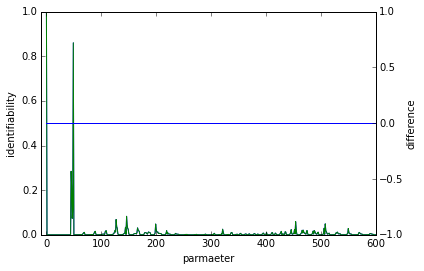

In [22]:
fig = plt.figure()
ax = plt.subplot(111)
axt = plt.twinx()
ax.plot(identpar_df["identifiability"])
ax.plot(df["ident"])
ax.set_xlim(-10,600)
diff = identpar_df["identifiability"].values - df["ident"].values
#print(diff)
axt.plot(diff)
axt.set_ylim(-1,1)
ax.set_xlabel("parameter")
ax.set_ylabel("identifiability")
axt.set_ylabel("difference")